In [1]:
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
%pip install -r requirements.txt
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197
Receiving objects: 100% (1197/1197), 74.23 MiB | 35.03 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/kaggle/working/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-nlp

In [2]:
# copy dataset to data folder
%cp -r /kaggle/input/sr-det-512/SR-DET-512/sat-gen-coco-512x512 ./data

# create "images" folder and move all *.jpg files into it
%mkdir ./data/sat-gen-coco-512x512/train/images
%mv ./data/sat-gen-coco-512x512/train/*.jpg ./data/sat-gen-coco-512x512/train/images

%mkdir ./data/sat-gen-coco-512x512/valid/images
%mv ./data/sat-gen-coco-512x512/valid/*.jpg ./data/sat-gen-coco-512x512/valid/images

%mkdir ./data/sat-gen-coco-512x512/test/images
%mv ./data/sat-gen-coco-512x512/test/*.jpg ./data/sat-gen-coco-512x512/test/images

# create "annotations" folder and move all *.json file into it
%mkdir ./data/sat-gen-coco-512x512/annotations
%mv ./data/sat-gen-coco-512x512/train/_annotations.coco.json ./data/sat-gen-coco-512x512/annotations/train.json
%mv ./data/sat-gen-coco-512x512/valid/_annotations.coco.json ./data/sat-gen-coco-512x512/annotations/valid.json
%mv ./data/sat-gen-coco-512x512/test/_annotations.coco.json ./data/sat-gen-coco-512x512/annotations/test.json


In [3]:
import json

# read a json file for example
with open('./data/sat-gen-coco-512x512/annotations/valid.json', 'r') as f:
    json_data = json.load(f)

# print the keys of the json file
print('Keys of the json file: ', json_data.keys())

# print categories for example
print('Categories: ', json_data['categories'])

# print an image for example
print('Content of an image: ', json_data['images'][0])

# print the content of an annotation for example
print('Content of an annotation: ', json_data['annotations'][0])

Keys of the json file:  dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Categories:  [{'id': 0, 'name': 'car-plane-boat', 'supercategory': 'none'}, {'id': 1, 'name': 'airplane', 'supercategory': 'car-plane-boat'}, {'id': 2, 'name': 'boat', 'supercategory': 'car-plane-boat'}, {'id': 3, 'name': 'car', 'supercategory': 'car-plane-boat'}, {'id': 4, 'name': 'cargo ship', 'supercategory': 'car-plane-boat'}, {'id': 5, 'name': 'fighter jet', 'supercategory': 'car-plane-boat'}, {'id': 6, 'name': 'helicopter', 'supercategory': 'car-plane-boat'}, {'id': 7, 'name': 'jet', 'supercategory': 'car-plane-boat'}, {'id': 8, 'name': 'military aircraft', 'supercategory': 'car-plane-boat'}, {'id': 9, 'name': 'propeller plane', 'supercategory': 'car-plane-boat'}, {'id': 10, 'name': 'truck', 'supercategory': 'car-plane-boat'}, {'id': 11, 'name': 'yacht', 'supercategory': 'car-plane-boat'}]
Content of an image:  {'id': 0, 'license': 1, 'file_name': 'car449_jpg.rf.02221c4d220cfb15a21f5639

In [4]:
!echo -e 'train: data/sat-gen-coco-512x512/train/images\nval: data/sat-gen-coco-512x512/valid/images\n\nnc: 11\nnames: ["airplane", "boat", "car", "cargo ship", "fighter jet", "helicopter", "jet", "military aircraft", "propeller plane", "truck", "yacht"]' > data/satcoco.yaml  # write a yaml file
!head data/satcoco.yaml  #display content

train: data/sat-gen-coco-512x512/train/images
val: data/sat-gen-coco-512x512/valid/images

nc: 11
names: ["airplane", "boat", "car", "cargo ship", "fighter jet", "helicopter", "jet", "military aircraft", "propeller plane", "truck", "yacht"]


In [5]:
import json
from pathlib import Path

def convert_annotations(annotation_path, target_path):
    # create a new folder for labels
    p = Path(target_path).mkdir(parents = True, exist_ok = True)
    
    # read annotation
    # You can also use pycocotools for COCO format annotations
    with open(annotation_path, 'r') as j:
        json_data = json.load(j)
        
    # get the image attributes we will use to normalize and output labels
    imgs = {}
    for img in json_data['images']:
        imgs[img['id']] = {
            'file_name': Path(img['file_name']).stem,  # remove extension
            'height': img['height'], 
            'width': img['width'],
        }
        
    # create labels
    for annotation in json_data['annotations']:
        attributes = imgs[annotation['image_id']]  # get image attributes by using image id
        category_id = int(annotation['category_id']) - 1  # zero-based, -1 to match the class id
        x, y, w, h = annotation['bbox']  # get bounding box information
        label = [category_id, ((2 * x + w) / (2 * attributes['width'])) , ((2 * y + h) / (2 * attributes['height'])), (w / attributes['width']), (h / attributes['height'])]  # record and normalize
        
        # write labels
        file_name = attributes['file_name']
        with open(f'{target_path}/{file_name}.txt', 'a') as f:  # use 'a' for append
            f.write(' '.join(map(str, label)) + "\n")  # convert to string and write to file
        
    
for folder in ['train', 'valid']:  # convert order: train -> val, you can also add 'test' if you want to use it
    convert_annotations(
        annotation_path = f'data/sat-gen-coco-512x512/annotations/{folder}.json',  # annotation file
        target_path = f'data/sat-gen-coco-512x512/{folder}/labels',  # labels folder
    )

In [6]:
!cat cfg/training/yolov7.yaml  # display content

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2      
   [-1, 1, Conv, [64, 3, 1]],
   
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4  
   [-1, 1, Conv, [64, 1, 1]],
   [-2, 1, Conv, [64, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],  # 11
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 16-P3/8  
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],

In [7]:
!cp cfg/training/yolov7.yaml cfg/training/yolov7_small_object.yaml  # copy

In [8]:
# define P2
P2_layers = [
    '   #################### FPN P2 ####################\n', 
    '   [-1, 1, Conv, [128, 1, 1]],\n', 
    '   [-2, 1, Conv, [128, 1, 1]],\n', 
    '   [-1, 1, Conv, [64, 3, 1]],\n', 
    '   [-1, 1, Conv, [64, 3, 1]],\n', 
    '   [-1, 1, Conv, [64, 3, 1]],\n', 
    '   [-1, 1, Conv, [64, 3, 1]],\n', 
    '   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],\n', 
    '   [-1, 1, Conv, [128, 1, 1]], # 75\n', 
    '\n', 
    '   [-1, 1, Conv, [64, 1, 1]],\n', 
    "   [-1, 1, nn.Upsample, [None, 2, 'nearest']],\n", 
    '   [11, 1, Conv, [64, 1, 1]], # route backbone P2\n', 
    '   [[-1, -2], 1, Concat, [1]], # 79\n', 
    '   #################### FPN P2 ####################\n', 
    '\n', 
    '   #################### PAN P2 ####################\n', 
    '   [-1, 1, Conv, [64, 1, 1]],\n', 
    '   [-2, 1, Conv, [64, 1, 1]],\n', 
    '   [-1, 1, Conv, [32, 3, 1]],\n', 
    '   [-1, 1, Conv, [32, 3, 1]],\n', 
    '   [-1, 1, Conv, [32, 3, 1]],\n', 
    '   [-1, 1, Conv, [32, 3, 1]],\n', 
    '   [[-1, -2, -3, -4, -5, -6], 1, Concat, [1]],\n', 
    '   [-1, 1, Conv, [64, 1, 1]], # 87\n', 
    '\n', 
    '   [-1, 1, MP, []],\n', 
    '   [-1, 1, Conv, [64, 1, 1]],\n', 
    '   [-3, 1, Conv, [64, 1, 1]],\n', 
    '   [-1, 1, Conv, [64, 3, 2]],\n', 
    '   [[-1, -3, 75], 1, Concat, [1]],  # 92\n', 
    '   #################### PAN P2 ####################\n'
    '\n', 
]

In [9]:
# read yaml file
with open('cfg/training/yolov7_small_object.yaml', 'r') as f:
    lines = f.readlines()

# add P2 layers and remove P5 layers
lines = lines[: 95] + P2_layers + lines[95 : 119] + lines[134 :]
    
# modify content for correct layers
## parameters and anchors ##
lines[1] = lines[1].replace('80', '11')  # number of class from 80 to 3
lines[7] = lines[7].replace('P3/8', 'P2/4')  # modify comment, move anchor from P3 to P2
lines[8] = lines[8].replace('P4/16', 'P3/8')  # modify comment, move anchor from P4 to P3
lines[9] = lines[9].replace('P5/32', 'P4/16')  # modify comment, move anchor from P5 to P4

## head ##
lines[134] = lines[134].replace('75', '100')  # layer number change: from 75 to 100
lines[149] = lines[149].replace('88', '113')  # layer number change: from 88 to 113

## RepConv ##
lines[151] = lines[151].replace('75', '87').replace('256', '128')  # from layer number change: from 75 to 87. RepConv change: 256 to 128
lines[152] = lines[152].replace('88', '100').replace('512', '256')  # from layer number change: from 88 to 100. RepConv change: 512 to 256
lines[153] = lines[153].replace('101', '113').replace('1024', '512')  # from layer number change: from 101 to 113. RepConv change: 1024 to 512

lines[155] = lines[155].replace('102,103,104', '114, 115, 116').replace('P3, P4, P5', 'P2, P3, P4')  # concat all RepConv layers

# write yaml file
with open('cfg/training/yolov7_small_object.yaml', 'w') as w:
    w.write(''.join(lines))

In [10]:
!cat cfg/training/yolov7_small_object.yaml  # check

# parameters
nc: 11  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P2/4
  - [36,75, 76,55, 72,146]  # P3/8
  - [142,110, 192,243, 459,401]  # P4/16

# yolov7 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
  
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2      
   [-1, 1, Conv, [64, 3, 1]],
   
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4  
   [-1, 1, Conv, [64, 1, 1]],
   [-2, 1, Conv, [64, 1, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [-1, 1, Conv, [64, 3, 1]],
   [[-1, -3, -5, -6], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],  # 11
         
   [-1, 1, MP, []],
   [-1, 1, Conv, [128, 1, 1]],
   [-3, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 2]],
   [[-1, -3], 1, Concat, [1]],  # 16-P3/8  
   [-1, 1, Conv, [128, 1, 1]],
   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, Conv, [128, 3, 1]],


In [11]:
!wandb disabled

W&B disabled.


In [12]:
!rm -rf runs/train
!python train.py --img 512 --batch-size 12 --workers 8 --weights 'yolov7_training.pt' --cfg cfg/training/yolov7_small_object.yaml --hyp data/hyp.scratch.p5.yaml --data data/satcoco.yaml --device 0 --epoch 200

2024-03-26 06:42:27.382922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 06:42:27.383107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 06:42:27.515872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
train: Scanning 'data/sat-gen-coc

In [13]:
!rm -rf runs/test
!python test.py --img 512 --batch-size 12 --conf 0.001 --iou 0.65 --data data/satcoco.yaml --device 0 --weights runs/train/exp/weights/best.pt

Namespace(weights=['runs/train/exp/weights/best.pt'], data='data/satcoco.yaml', batch_size=12, img_size=512, conf_thres=0.001, iou_thres=0.65, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

val: Scanning 'data/sat-gen-coco-512x512/valid/labels.cache' images and labels..
               Class      Im

In [14]:
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.25 --source data/sat-gen-coco-512x512/test/images

Namespace(weights=['runs/train/exp/weights/best.pt'], source='data/sat-gen-coco-512x512/test/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

3 boats, 1 car, 1 truck, 2 yachts, Done. (24.3ms) Inference, (293.0ms) NMS
 The image with the result is saved in: runs/d

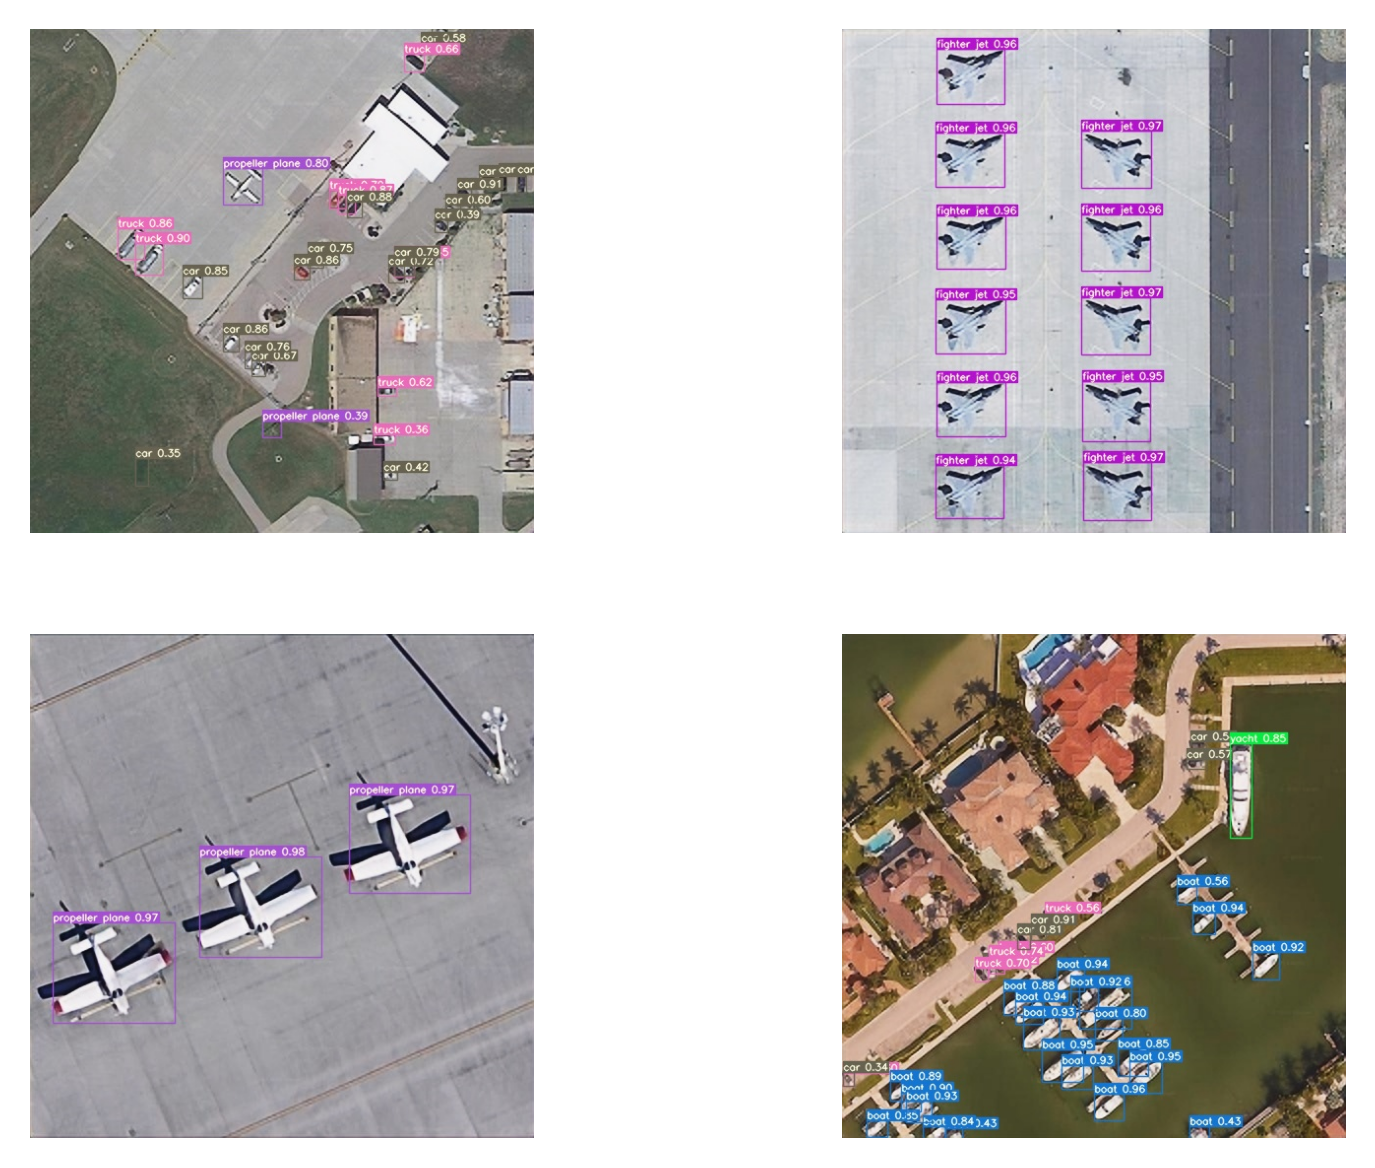

In [15]:
import cv2
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

fig, ax = plt.subplots(2, 2)  # plot 2 x 2 images
fig.set_dpi(300)
base_path = 'runs/detect/exp'
images = [base_path + '/' + f for f in listdir(base_path) if isfile(join(base_path, f))]

for i in range(2):  # 0 - 2
    img1 = cv2.imread(images[2 * i], cv2.IMREAD_COLOR)  # read an image
    img2 = cv2.imread(images[(2 * i) + 1], cv2.IMREAD_COLOR)  # read another image

    ax[0][i].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # set the first image to row 0
    ax[1][i].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # set the second image to row 1

    ax[0][i].axis('off')  # set axis off
    ax[1][i].axis('off')  # set axis off